# 00 - Environment Test

This notebook verifies that your development environment is correctly set up for the PINN project.

**Run all cells in order. If you see green checkmarks (✅) at the end, you're good to go!**

## 1. Test Core Packages

In [1]:
# Test imports
import sys
print(f"Python version: {sys.version}")
print()

# Core packages
import numpy as np
print(f"✅ NumPy {np.__version__}")

import matplotlib
print(f"✅ Matplotlib {matplotlib.__version__}")

import pandas as pd
print(f"✅ Pandas {pd.__version__}")

import scipy
print(f"✅ SciPy {scipy.__version__}")

# PyTorch
import torch
print(f"✅ PyTorch {torch.__version__}")
print(f"   CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name(0)}")

# DeepXDE
try:
    import deepxde
    print(f"✅ DeepXDE {deepxde.__version__}")
except ImportError:
    print("⚠️ DeepXDE not installed (optional for now)")

Python version: 3.10.19 | packaged by Anaconda, Inc. | (main, Oct 21 2025, 16:41:31) [MSC v.1929 64 bit (AMD64)]

✅ NumPy 2.2.6
✅ Matplotlib 3.10.8
✅ Pandas 2.3.3
✅ SciPy 1.15.3


No backend selected.
Finding available backend...
Found pytorch
Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


✅ PyTorch 2.10.0+cpu
   CUDA available: False
Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
✅ DeepXDE 1.15.0


## 2. Test PyTorch Autograd (Core of PINNs!)

This is the most important test. PINNs rely on automatic differentiation to compute PDE residuals.

In [2]:
import torch

# Test: compute derivative of f(x) = x^3 + 2x^2 - 5x + 3
# Analytical derivative: f'(x) = 3x^2 + 4x - 5

x = torch.tensor([2.0], requires_grad=True)

# Compute function
y = x**3 + 2*x**2 - 5*x + 3

# Compute gradient using autograd
y.backward()

# Check result
computed_gradient = x.grad.item()
expected_gradient = 3*(2**2) + 4*2 - 5  # = 12 + 8 - 5 = 15

print(f"Function: y = x³ + 2x² - 5x + 3")
print(f"At x = 2:")
print(f"  y = {y.item()}")
print(f"  dy/dx (computed) = {computed_gradient}")
print(f"  dy/dx (expected) = {expected_gradient}")
print()

if abs(computed_gradient - expected_gradient) < 1e-6:
    print("✅ Autograd is working correctly!")
else:
    print("❌ Something is wrong with autograd")

Function: y = x³ + 2x² - 5x + 3
At x = 2:
  y = 9.0
  dy/dx (computed) = 15.0
  dy/dx (expected) = 15

✅ Autograd is working correctly!


## 3. Test Second Derivatives (Needed for Diffusion Term)

The diffusion term ∇²C requires second derivatives.

In [3]:
import torch

# Test: compute second derivative of f(x) = sin(x)
# f'(x) = cos(x), f''(x) = -sin(x)

x = torch.tensor([1.0], requires_grad=True)

# Compute function
y = torch.sin(x)

# First derivative
dy_dx = torch.autograd.grad(y, x, create_graph=True)[0]

# Second derivative
d2y_dx2 = torch.autograd.grad(dy_dx, x)[0]

print(f"Function: y = sin(x)")
print(f"At x = 1:")
print(f"  y = sin(1) = {y.item():.6f}")
print(f"  dy/dx = cos(1) = {dy_dx.item():.6f} (expected: {torch.cos(torch.tensor(1.0)).item():.6f})")
print(f"  d²y/dx² = -sin(1) = {d2y_dx2.item():.6f} (expected: {-torch.sin(torch.tensor(1.0)).item():.6f})")
print()

if abs(d2y_dx2.item() + torch.sin(torch.tensor(1.0)).item()) < 1e-5:
    print("✅ Second derivatives working correctly!")
else:
    print("❌ Issue with second derivatives")

Function: y = sin(x)
At x = 1:
  y = sin(1) = 0.841471
  dy/dx = cos(1) = 0.540302 (expected: 0.540302)
  d²y/dx² = -sin(1) = -0.841471 (expected: -0.841471)

✅ Second derivatives working correctly!


## 4. Test Simple Neural Network

In [4]:
import torch
import torch.nn as nn

# Create a simple neural network
class SimpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.layers(x)

# Create model and test forward pass
model = SimpleNet()
print(f"Model architecture:")
print(model)
print()

# Count parameters
num_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {num_params:,}")

# Test forward pass
x_test = torch.rand(10, 2)  # 10 samples, 2 inputs (x, t)
y_test = model(x_test)
print(f"\nInput shape: {x_test.shape}")
print(f"Output shape: {y_test.shape}")
print("\n✅ Neural network working correctly!")

Model architecture:
SimpleNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)

Total parameters: 1,185

Input shape: torch.Size([10, 2])
Output shape: torch.Size([10, 1])

✅ Neural network working correctly!


## 5. Test Neural Network + Autograd (This is How PINNs Work!)

In [5]:
import torch
import torch.nn as nn

# Same network as before
model = SimpleNet()

# Create input with gradient tracking
x = torch.rand(100, 1, requires_grad=True)
t = torch.rand(100, 1, requires_grad=True)
inputs = torch.cat([x, t], dim=1)

# Forward pass: C = network(x, t)
C = model(inputs)

# Compute partial derivatives using autograd
# This is exactly what we do in PINNs!

# ∂C/∂x
dC_dx = torch.autograd.grad(
    outputs=C, 
    inputs=x,
    grad_outputs=torch.ones_like(C),
    create_graph=True
)[0]

# ∂C/∂t
dC_dt = torch.autograd.grad(
    outputs=C,
    inputs=t,
    grad_outputs=torch.ones_like(C),
    create_graph=True
)[0]

# ∂²C/∂x² (needed for diffusion!)
d2C_dx2 = torch.autograd.grad(
    outputs=dC_dx,
    inputs=x,
    grad_outputs=torch.ones_like(dC_dx),
    create_graph=True
)[0]

print("Computing derivatives of neural network output:")
print(f"  C shape: {C.shape}")
print(f"  ∂C/∂x shape: {dC_dx.shape}")
print(f"  ∂C/∂t shape: {dC_dt.shape}")
print(f"  ∂²C/∂x² shape: {d2C_dx2.shape}")
print()

# Now we can compute a physics residual!
# For advection-diffusion: ∂C/∂t + u*∂C/∂x - D*∂²C/∂x² = 0
u = 1.0  # advection velocity
D = 0.1  # diffusion coefficient

residual = dC_dt + u * dC_dx - D * d2C_dx2
physics_loss = torch.mean(residual**2)

print(f"Physics residual mean: {residual.mean().item():.6f}")
print(f"Physics loss (MSE): {physics_loss.item():.6f}")
print()
print("✅ Neural network + autograd working correctly!")
print("   This is the core mechanism of PINNs!")

Computing derivatives of neural network output:
  C shape: torch.Size([100, 1])
  ∂C/∂x shape: torch.Size([100, 1])
  ∂C/∂t shape: torch.Size([100, 1])
  ∂²C/∂x² shape: torch.Size([100, 1])

Physics residual mean: 0.062380
Physics loss (MSE): 0.004508

✅ Neural network + autograd working correctly!
   This is the core mechanism of PINNs!


## 6. Test Plotting

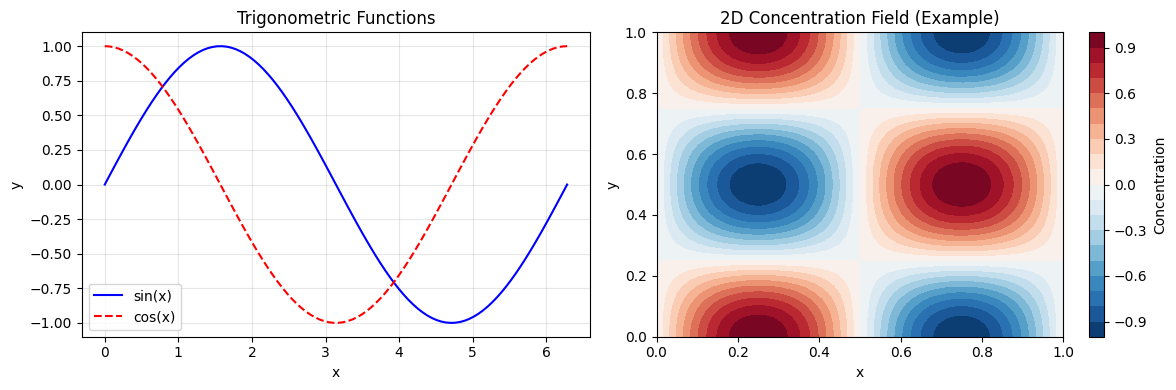

✅ Plotting working correctly!


In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Create a sample plot
x = np.linspace(0, 2*np.pi, 100)
y1 = np.sin(x)
y2 = np.cos(x)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(x, y1, 'b-', label='sin(x)')
ax1.plot(x, y2, 'r--', label='cos(x)')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Trigonometric Functions')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2D heatmap (like we'll use for concentration fields)
xx, yy = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
zz = np.sin(2*np.pi*xx) * np.cos(2*np.pi*yy)

im = ax2.contourf(xx, yy, zz, levels=20, cmap='RdBu_r')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_title('2D Concentration Field (Example)')
plt.colorbar(im, ax=ax2, label='Concentration')

plt.tight_layout()
plt.show()

print("✅ Plotting working correctly!")

## 7. Test Our Custom Modules

In [7]:
import sys
sys.path.insert(0, '..')  # Add parent directory to path

try:
    from src.models import PINN_1D, PINN_2D
    from src.physics import compute_gradients, PhysicsLoss
    from src.data import generate_collocation_points_1d, normalize_data
    
    print("✅ Custom modules imported successfully!")
    print("   - src.models: PINN_1D, PINN_2D")
    print("   - src.physics: compute_gradients, PhysicsLoss")
    print("   - src.data: generate_collocation_points_1d, normalize_data")
    
except ImportError as e:
    print(f"⚠️ Could not import custom modules: {e}")
    print("   This is OK for now - modules will be available once you set up the folder structure")

✅ Custom modules imported successfully!
   - src.models: PINN_1D, PINN_2D
   - src.physics: compute_gradients, PhysicsLoss
   - src.data: generate_collocation_points_1d, normalize_data


## 🎉 Summary

In [ ]:
print("="*60)
print("ENVIRONMENT TEST COMPLETE")
print("="*60)
print()
print("If you see ✅ for all tests above, your environment is ready!")
print()
print("Key capabilities verified:")
print("  ✅ PyTorch installed and working")
print("  ✅ Autograd computes first derivatives")
print("  ✅ Autograd computes second derivatives")
print("  ✅ Neural networks work with autograd")
print("  ✅ Plotting works")
print()
print("You're ready to start building PINNs! 🚀")
print()
print("Next step: Open notebook 01_pytorch_basics.ipynb")